# Evaluation of Deterministic Masking of Ascon

This notebook is based on the original [simpleserial-ascon](https://github.com/ascon/simpleserial-ascon) repository and has been adapted to evaluate the **side-channel resistance** of our **deterministically masked** implementations of Ascon.

For background on the original codebase and implementation details, please refer to the upstream repository.

> **Note: Setup Instructions**
>
> - This notebook should be placed inside the `jupyter` folder of your ChipWhisperer installation.
> - The modified implementation should be cloned into the firmware directory as follows:
>
>   ```bash
>   cd hardware/victims/firmware
>   git clone https://github.com/vahid-jahandideh/deterministic-masking-ascon.git
>   ```
>
> - Set `SS_SHARED = 1` to transfer input data as **masked shares** and call `crypto_aead_encrypt_shared` or `crypto_aead_decrypt_shared`.
> - Set `SS_SHARED = 0` to transfer input data in **plain format** and call `crypto_aead_encrypt` or `crypto_aead_decrypt`.


In [10]:
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET = 'NONE'
SCOPETYPE = 'OPENADC'
SS_VER = 'SS_VER_2_1'
BAUD_RATE = 230400
SS_SHARED = 1
DATA_LEN = 190
RESP_LEN = 96
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.clock.adc_freq                     changed from 19083286                  to 28798496                 
scope.clock.adc_rate                     changed from 19083286.0                to 28798496.0               


### Setup Target Algorithm

In [11]:
CRYPTO_PATH = 'Implementations/crypto_aead/ascon128v12/protected_bi32_armv6'
NUM_SHARES_KEY = 3
NUM_SHARES_NPUB = NUM_SHARES_KEY
NUM_SHARES_AD = NUM_SHARES_KEY
NUM_SHARES_M = NUM_SHARES_KEY
NUM_SHARES_C = NUM_SHARES_KEY
ASCON_ROR_SHARES = 5
ASCON_EXTERN_BI = 0
ASCON_EXTERN_BE = 1
ASCON_PA_ROUNDS = 12 
ASCON_PB_ROUNDS = 6 

## Compile

In [12]:
%%bash -s "$SS_VER" "$PLATFORM" "$CRYPTO_TARGET" "$CRYPTO_PATH" "$EXTRA_OPTS" "-Os"
cd ../hardware/victims/firmware/deterministic-masked-ascon
rm -rf objdir-$2/$4 objdir/$4 objdir .dep
mkdir -p objdir-$2/$4 objdir/$4
make SS_VER=$1 PLATFORM=$2 CRYPTO_TARGET=$3 CRYPTO_PATH=$4 EXTRA_OPTS="$5" OPT=s

Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
mkdir -p .dep
Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     simpleserial-ascon.c ...
-e Done!
.
Compiling:
-en     randombytes.c ...
-e Done!
.
Compiling:
-en     Implementations/crypto_aead/ascon128v12/protected_bi32_armv6/aead.c ...
-e Done!
.
Compiling:
-en     Implementations/crypto_aead/ascon128v12/protected_bi32_armv6/constants.c ...
-e Done!
.
Compiling:
-en   

## Flash Binary on the Victim Board

In [14]:
HEXFILE = "../hardware/victims/firmware/deterministic-masked-ascon/simpleserial-ascon-" + PLATFORM + ".hex"
cw.program_target(scope, prog, HEXFILE)

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 19111 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 19111 bytes


## Communication Test

In [15]:
target.flush()

try:
    target.baud = BAUD_RATE
except:
    pass

print('Baudrate:')
print(target.baud)

print('Available Commands:')
print(*target.get_simpleserial_commands(),sep = "\n")
import time

CMD_ECHO_TEST = 'e'

data = bytearray.fromhex(''.join('{:02x}'.format(x) for x in list(range(DATA_LEN))))

target.flush()
target.simpleserial_write(CMD_ECHO_TEST, data)
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# SS_VER_2_1 commands:
#arget.send_cmd(CMD_ECHO_TEST, 0x00, data)
#response = target.read_cmd(cmd=None, pay_len=None, timeout=250, flush_on_err=None)

print(list(response))

Baudrate:
230400
Available Commands:
{'cmd': b'v', 'len': 0, 'flags': 0}
{'cmd': b'w', 'len': 0, 'flags': 0}
{'cmd': b'a', 'len': 0, 'flags': 0}
{'cmd': b'e', 'len': 0, 'flags': 0}


## Interface Functions

In [16]:
if SS_SHARED == 0:
    def size_shares(l, ns):
        return l
    def generate_shares(x, ns):
        return bytearray(x)
    def combine_shares(xs, ns):
        return bytearray(xs)
def pad(data):
    if len(data) > DATA_LEN:
        print("data length: " + str(len(data)))
    assert(len(data) <= DATA_LEN)
    if SS_VER == 'SS_VER_1_1':
        data += bytearray.fromhex('00'*(DATA_LEN-len(data)))
    return data

def bswap64(x):
    y = np.zeros((len(x)+7)//8*8, dtype=np.uint8)
    for i in range(len(x)):
        y[i // 8 * 8 + 7 - i % 8] = x[i]
    return y

def ror(v, r, s):
    return ((v & (2**s - 1)) >> (r % s) | (v << (s - (r % s)) & (2**s - 1)))

def tobi(x):
    y = np.zeros((len(x)+7)//8*8, dtype=np.uint8)
    for i in range(len(x)):
        for j in range(4):
            e = (x[i] >> (j * 2)) & 1
            o = (x[i] >> (j * 2 + 1)) & 1
            y[(i//8)*8+(i%8)//2] |= e << ((i%2) * 4 + j)
            y[(i//8)*8+(i%8)//2+4] |= o << ((i%2) * 4 + j)
    return y

def frombi(x):
    y = np.zeros((len(x)+7)//8*8, dtype=np.uint8)
    for i in range(len(x)):
        for j in range(4):
            e = (x[(i//8)*8+(i%8)//2] >> ((i%2) * 4 + j)) & 1
            o = (x[(i//8)*8+(i%8)//2+4] >> ((i%2) * 4 + j)) & 1
            y[i] |= e << (j * 2)
            y[i] |= o << (j * 2 + 1)
    return y

def size_shares(l, ns):
    return ((l + 7) // 8) * 8 * ns

def generate_shares(x, ns):
    l = size_shares(len(x), ns) // ns
    xs = np.zeros((l // 4, ns, 4), dtype=np.uint8)
    if ASCON_EXTERN_BE:
        x = bswap64(x)
    if ASCON_EXTERN_BI:
        x = tobi(x)
    for i in range(len(x)):
        xs[i // 4][0][i % 4] = x[i]
    for i in range(0, l // 4, 2):
        for j in range(1, ns):
            r0 = random.getrandbits(32)
            r1 = random.getrandbits(32)
            if ASCON_EXTERN_BI:
                m = ror(r1, ASCON_ROR_SHARES * j, 32) << 32 | ror(r0, ASCON_ROR_SHARES * j, 32)
            else:
                m = ror(r1 << 32 | r0, 2 * ASCON_ROR_SHARES * j, 64)
            for k in range(4):
                xs[i + 0][0][k] ^= (m >> (k * 8)) & 0xff
                xs[i + 1][0][k] ^= (m >> (k * 8 + 32)) & 0xff
                xs[i + 0][j][k] ^= (r0 >> (k * 8)) & 0xff
                xs[i + 1][j][k] ^= (r1 >> (k * 8)) & 0xff
    xs = xs.flatten()
    return bytearray(xs)
    
def combine_shares(xs, ns):
    l = len(xs) // ns
    xs = np.reshape(xs, (l // 4, ns, 4))
    x = np.zeros((l // 4, 4), dtype=np.uint8)
    for i in range(0, l // 4, 2):
        for j in range(ns):
            r0 = r1 = 0
            for k in range(4):
                r0 |= int(xs[i + 0][j][k]) << (k * 8)
                r1 |= int(xs[i + 1][j][k]) << (k * 8)
            if ASCON_EXTERN_BI:
                m = ror(r1, ASCON_ROR_SHARES * j, 32) << 32 | ror(r0, ASCON_ROR_SHARES * j, 32)
            else:
                m = ror(r1 << 32 | r0, 2 * ASCON_ROR_SHARES * j, 64)
            for k in range(4):
                x[i + 0][k] ^= (m >> (k * 8)) & 0xff
                x[i + 1][k] ^= (m >> (k * 8 + 32)) & 0xff
    x = x.flatten()
    if ASCON_EXTERN_BI:
        x = frombi(x)
    if ASCON_EXTERN_BE:
        x = bswap64(x)
    return bytearray(x)

### One Encryption Test

In [25]:
import numpy as np
import random

# Command
CMD_ASCON = 'a'
CMD_ECHO_TEST = 'e'

# Flags
M = 0x01              # data contains message 
C = 0x02              # data contains ciphertext
A = 0x04              # data contains associated data
N = 0x08              # data contains nonce
K = 0x10              # data contains key
RUN_ENC = 0x20        # run enc after data transmission
RUN_DEC = 0x40        # run dec after data transmission
OMIT_RESULT = 0x80    # omit returning result after encryption/decryption

# Define input data
m = bytearray.fromhex('00010203')
a = bytearray.fromhex('00010203')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
Expected_c = bytearray.fromhex('7763f8ba')
Expected_t = bytearray.fromhex('02b1e06bc3f2370da5b314302543e9d0')
# Send nonce and key
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

# Send and receive data
data = bytearray([M|A|RUN_ENC])
data += bytearray([len(m)]) + generate_shares(m, NUM_SHARES_M)
data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# Extract and print response
mlen = size_shares(len(m), NUM_SHARES_C)
tlen = size_shares(16, NUM_SHARES_C)
c = combine_shares(response[0:mlen], NUM_SHARES_C)
t = combine_shares(response[mlen:mlen + tlen], NUM_SHARES_C)
passed =1
if(c[:len(m)]!=Expected_c):
 print('Got c: ' + ''.join('{:02x}'.format(x) for x in c[:len(m)]))
 print('but expected c: ' + ''.join('{:02x}'.format(x) for x in Expected_c[:len(m)]))
 passed = 0
if(t!=Expected_t): 
 print('Got t: ' + ''.join('{:02x}'.format(x) for x in t))
 print('but expected t: ' + ''.join('{:02x}'.format(x) for x in Expected_t))
 passed =0
if(passed==1):
 print("Test Successfully Passed")


Got t: 02b1e06bc3f2370da5b314302543e9d0
but expected t: 02b1e06bc3f2370da5b314302543e9d1


In [21]:
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

bytes_ = []
cycles = []
scope.clock.adc_src = 'clkgen_x1'
for l in [2**x for x in range(6)]:
    m = bytearray([x for x in range(l)])
    a = bytearray([x for x in range(0)])
    # Define input data
    data = bytearray([M|A|RUN_ENC])
    data += bytearray([len(m)]) + generate_shares(m, NUM_SHARES_M)
    data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
    assert(len(data) <= DATA_LEN)
    # Send and receive data
    target.flush()
    scope.arm()
    begin = scope.adc.trig_count
    target.simpleserial_write(CMD_ASCON, pad(data))
    response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)
    end = scope.adc.trig_count
    bytes_.append(l)
    cycles.append(end - begin)

print('         x + 0 encrypt        ')
print('------------------------------')
print('   bytes |   cycles |      c/b')
print('------------------------------')
for i in range(len(bytes_)):
    print(str(bytes_[i]).rjust(8) + ' | ', end='')
    print(str(cycles[i]).rjust(8) + ' | ', end='')
    print(str(int(cycles[i] / max(bytes_[i], 1))).rjust(8))
print('long'.rjust(8) + ' | ', end='')
print('-'.rjust(8) + ' | ', end='')
print(str(int(((cycles[-1] - cycles[-2])) / (bytes_[-1] - bytes_[-2]))).rjust(8))

         x + 0 encrypt        
------------------------------
   bytes |   cycles |      c/b
------------------------------
       1 |    25414 |    25414
       2 |    25414 |    12707
       4 |    25414 |     6353
       8 |    31027 |     3878
      16 |    36993 |     2312
      32 |    48925 |     1528
    long |        - |      745


## First-order T-test

  0%|          | 98/1000000 [00:07<19:19:53, 14.37it/s]

samples: 31229


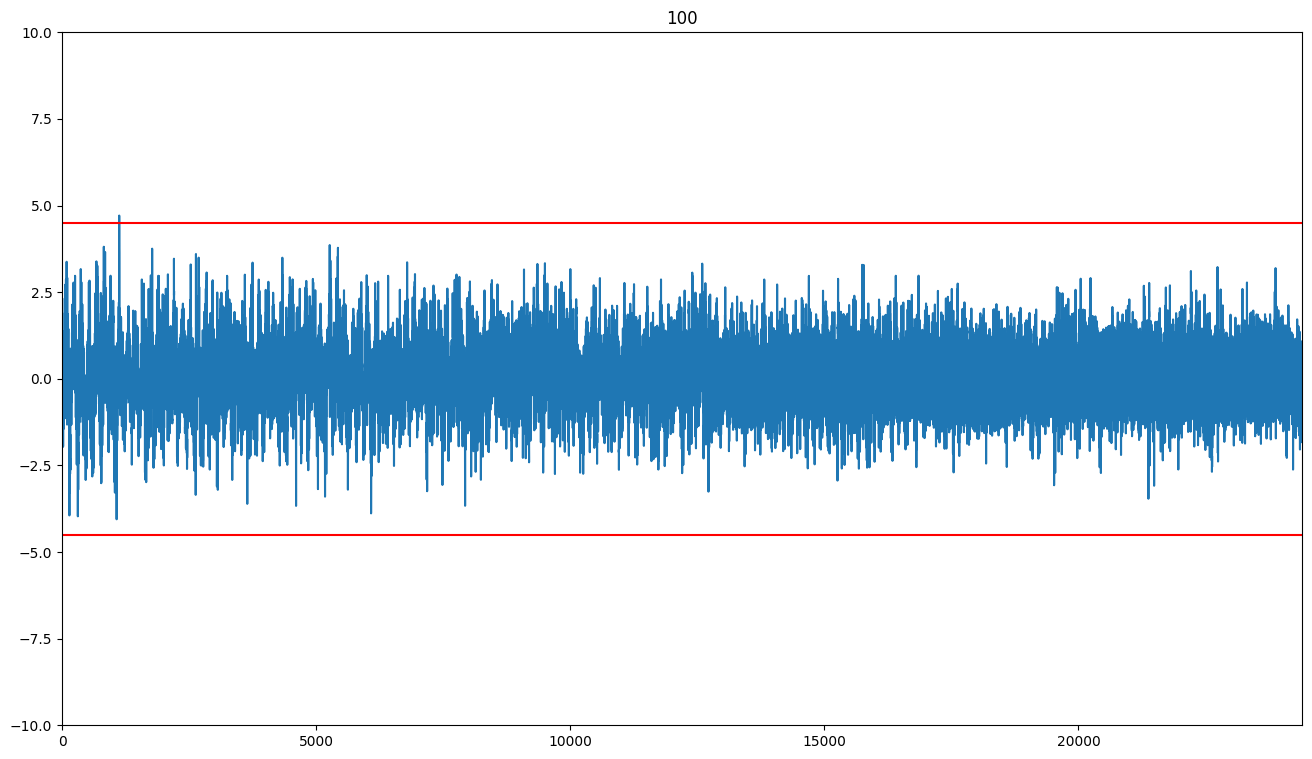

  0%|          | 998/1000000 [01:21<24:22:06, 11.39it/s] 

samples: 31229


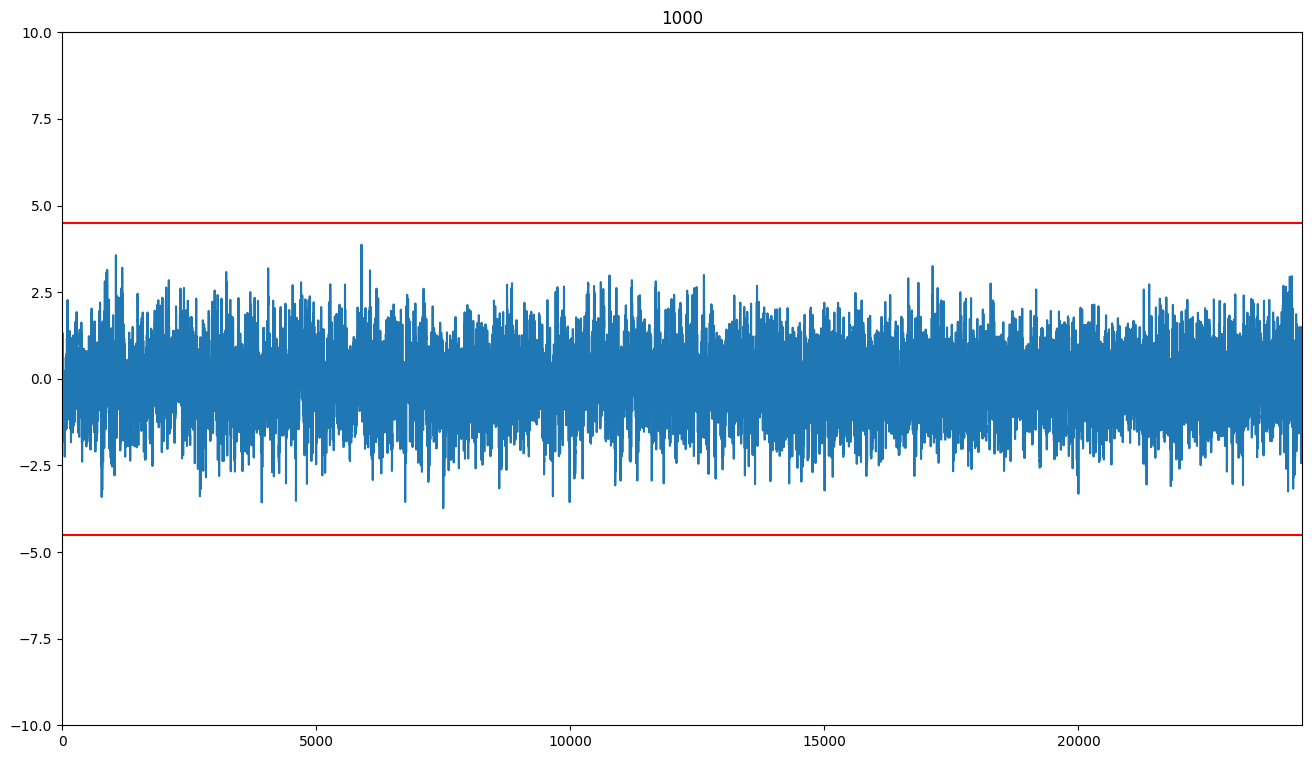

  0%|          | 1173/1000000 [01:37<23:01:16, 12.05it/s] 


KeyboardInterrupt: 

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pathlib
from tqdm import tqdm
import time

# Measurement settings
traces = 1000000
samples_per_trace = 24400

# Variables for one-pass 1st-order t-test
n_fix = 0
n_rnd = 0
S1_fix = np.zeros((samples_per_trace,),dtype=np.double)
S1_rnd = np.zeros((samples_per_trace,),dtype=np.double)
S2_fix = np.zeros((samples_per_trace,),dtype=np.double)
S2_rnd = np.zeros((samples_per_trace,),dtype=np.double)

# Define input data
m = bytearray.fromhex('')
a = bytearray.fromhex('')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
c = bytearray.fromhex('000102030405060708090a0b0c0d0e0f10111213')

#flags = M|A|N|RUN_ENC|OMIT_RESULT
flags = N|RUN_ENC|OMIT_RESULT
#flags = C|A|N|RUN_DEC|OMIT_RESULT

# Send key with data for less than 4 shares (data length <= 190 Bytes)
if NUM_SHARES_KEY < 4:
    flags |= K

# No adata for 3 shares and decryption (data length <= 190 Bytes)
if (NUM_SHARES_KEY >= 3) and (flags & C):
    a = bytearray.fromhex('')

target.flush()
scope.adc.samples = samples_per_trace
scope.clock.adc_src = 'clkgen_x1'  

progress = sorted(set([100, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000 ,500000, traces]))
for i in tqdm(range(traces)):
    if NUM_SHARES_KEY >= 4:
        # Send key separately
        data = bytearray([K])
        data += generate_shares(k, NUM_SHARES_KEY)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.02)
    # Setup data #
    data = bytearray([flags])
    coinflip = random.getrandbits(1)
    if coinflip:
        # Fix input
        if flags & RUN_ENC:
            data += bytearray([len(m)])
            data += generate_shares(m, NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(c[0:-16], NUM_SHARES_C)
            data += generate_shares(c[-16:], NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(a, NUM_SHARES_AD)
        data += generate_shares(n, NUM_SHARES_NPUB)
    else:
        # Random input
        if flags & RUN_ENC:
            data += bytearray([len(m)]) 
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(m)))), NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(c)-16))), NUM_SHARES_C)
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(16))), NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(a)))), NUM_SHARES_AD)
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(n)))), NUM_SHARES_NPUB)
    if NUM_SHARES_KEY < 4:
        data += generate_shares(k, NUM_SHARES_KEY)
    # Measure trace #
    scope.arm()
    target.simpleserial_write(CMD_ASCON, pad(data))
    scope.capture()
    trace = scope.get_last_trace()   
    if i == 0:
        samples_per_trace = min(scope.adc.trig_count,samples_per_trace)
    # Process trace #
    if coinflip:
        n_fix += 1
        S1_fix += trace
        S2_fix += np.square(trace)
    else:
        n_rnd += 1
        S1_rnd += trace
        S2_rnd += np.square(trace)
    if i+1 in progress or (i+1)%1000000 == 0:
        print("samples: " + str(scope.adc.trig_count))
        # Generate t-test plot
        mu_fix = S1_fix/n_fix
        mu_rnd = S1_rnd/n_rnd
        var_fix = S2_fix/n_fix - np.square(mu_fix)
        var_rnd = S2_rnd/n_rnd - np.square(mu_rnd)
        tscore = np.divide((mu_fix - mu_rnd),np.sqrt(var_fix/n_fix + var_rnd/n_rnd))
        tscore = tscore[:samples_per_trace]
        plt.figure(figsize=(16,9))
        plt.plot(tscore)
        plt.plot([0,len(tscore)-1],[4.5,4.5],'r-')
        plt.plot([0,len(tscore)-1],[-4.5,-4.5],'r-')
        plt.title(str(n_fix+n_rnd))
        plt.xlim((0,len(tscore)))
        plt.ylim((-10,10))
        pathlib.Path("ttest").mkdir(parents=True, exist_ok=True)
        plt.savefig("ttest/" + PLATFORM + "_{}.pdf".format(n_fix+n_rnd), format="pdf", bbox_inches='tight')
        plt.show()                

## Second-order T-test

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pathlib
from tqdm import tqdm
import time

# Measurement settings
traces = 1000000
samples_per_trace = 4000

# Variables for one-pass 1st-order t-test
n_fix = 0
n_rnd = 0
ind1 = 2500#1200
ind2 = 2750#1300
region_length = ind2 - ind1

S1_fix2 = np.zeros((region_length, region_length), dtype=np.double)
S1_rnd2 = np.zeros((region_length, region_length), dtype=np.double)
S2_fix2 = np.zeros((region_length, region_length), dtype=np.double)
S2_rnd2 = np.zeros((region_length, region_length), dtype=np.double)

# Define input data
m = bytearray.fromhex('')
a = bytearray.fromhex('')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
c = bytearray.fromhex('000102030405060708090a0b0c0d0e0f10111213')

#flags = M|A|N|RUN_ENC|OMIT_RESULT
flags = N|RUN_ENC|OMIT_RESULT
#flags = C|A|N|RUN_DEC|OMIT_RESULT

# Send key with data for less than 4 shares (data length <= 190 Bytes)
if NUM_SHARES_KEY < 4:
    flags |= K

# No adata for 3 shares and decryption (data length <= 190 Bytes)
if (NUM_SHARES_KEY >= 3) and (flags & C):
    a = bytearray.fromhex('')

target.flush()
scope.adc.samples = samples_per_trace
scope.clock.adc_src = 'clkgen_x1'  

progress = sorted(set([50,1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000 ,500000, traces]))
for i in tqdm(range(traces)):
    if NUM_SHARES_KEY >= 4:
        # Send key separately
        data = bytearray([K])
        data += generate_shares(k, NUM_SHARES_KEY)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.02)
    # Setup data #
    data = bytearray([flags])
    coinflip = random.getrandbits(1)
    if coinflip:
        # Fix input
        if flags & RUN_ENC:
            data += bytearray([len(m)])
            data += generate_shares(m, NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(c[0:-16], NUM_SHARES_C)
            data += generate_shares(c[-16:], NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(a, NUM_SHARES_AD)
        data += generate_shares(n, NUM_SHARES_NPUB)
    else:
        # Random input
        if flags & RUN_ENC:
            data += bytearray([len(m)]) 
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(m)))), NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(c)-16))), NUM_SHARES_C)
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(16))), NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(a)))), NUM_SHARES_AD)
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(n)))), NUM_SHARES_NPUB)
    if NUM_SHARES_KEY < 4:
        data += generate_shares(k, NUM_SHARES_KEY)
    # Measure trace #
    scope.arm()
    target.simpleserial_write(CMD_ASCON, pad(data))
    scope.capture()
    trace = scope.get_last_trace()      
    region = trace[ind1:ind2]
    if coinflip:
        n_fix +=1            
    else:
        n_rnd+=1

    for i_ in range(region_length):
     for j in range(i_, region_length):  # Only upper triangle (symmetric)
        z = region[i_] * region[j]
        if coinflip:           
            S1_fix2[i_][j] += z
            S2_fix2[i_][j] += z**2
        else:
            S1_rnd2[i_][j] += z
            S2_rnd2[i_][j] += z**2

    if i+1 in progress or (i+1)%1000000 == 0:        
        mu_fix2 = S1_fix2 / n_fix
        mu_rnd2 = S1_rnd2 / n_rnd
        var_fix2 = S2_fix2 / n_fix - mu_fix2**2
        var_rnd2 = S2_rnd2 / n_rnd - mu_rnd2**2
        denom = np.sqrt(var_fix2 / n_fix + var_rnd2 / n_rnd)
        with np.errstate(divide='ignore', invalid='ignore'):
            T = (mu_fix2 - mu_rnd2) / denom
            T[np.isnan(T)] = 0  # Clean up NaNs
        #for i_t1 in range(region_length):
        #    for j_t2 in range(i_t1):
        #        T[i_t1][j_t2] = T[j_t2][i_t1]

        # Plot 2D heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(T, cmap="seismic", vmin=-10, vmax=10, interpolation='none')
        plt.colorbar(label='t-score')
        plt.title(f"{n_fix + n_rnd}")
        plt.xlabel("Sample index j")
        plt.ylabel("Sample index i")

        # Optional: Overlay threshold contour
        plt.contour((np.abs(T) > 4.5).astype(int), colors='yellow', linewidths=0.5)

        plt.tight_layout()
        plt.savefig(f"ttest/{PLATFORM}_second_order_heatmap_{ind1}_{ind2}_{n_fix+n_rnd}.pdf", bbox_inches='tight')  
        plt.show()

## Disconnect from Board

In [ ]:
scope.dis()
target.dis()